In [27]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
# import LSTM_Train as LSTM
import importlib
import LSTM
importlib.reload(LSTM)

%matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm


def upper_confidence_bound(mu_x, sigma_x, opt_value, kappa=-1.0):
    return mu_x + kappa * sigma_x


# kernel = Matern()#length_scale = [1,1],length_scale_bounds="fixed")
# kernel = ConstantKernel(1e0, (1e-2, 1e2))*Matern(1e1, (1e-4, 1e4),nu = 2.5)\
# + WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-2, 1e2))
acq = upper_confidence_bound
def query(xi, yi, gp):
    best_value = np.inf

    for N in np.linspace(1,params['N_Max']):
        for T in np.linspace(0,params['T_Max']):
            def obj(x):
                x=x.reshape(1,-1)
                mu_x, sigma_x = gp.predict(x, return_std=True)
#                 print(np.min(yi),np.max(yi))
                return acq(mu_x, sigma_x, np.min(yi))
            x0 = np.asanyarray([N,T]).reshape(1,2)
            res = minimize(obj, x0, bounds=((1, params['N_Max']),(0,params['T_Max'])))

            if res.fun < best_value:
                best_value = res.fun
                query_point = res.x
    query_point = query_point
    return query_point



     N   T  MSE  STD
0   37   7  0.0  0.0
1   68   9  0.0  0.0
2   40  27  0.0  0.0
3   75  47  0.0  0.0
4    9  12  0.0  0.0
5   60  24  0.0  0.0
6   51  18  0.0  0.0
7   74  25  0.0  0.0
8   19  14  0.0  0.0
9   14   7  0.0  0.0
10  14  24  0.0  0.0
11  92  26  0.0  0.0
12  84  43  0.0  0.0
13  62  36  0.0  0.0
14  59  26  0.0  0.0
{'epochs': 600, 'Y': 'fch4', 'T_Max': 48, 'proc': 3, 'N_Max': 100, 'Searches': 8, 'reps': 15, 'N_Min': 2}


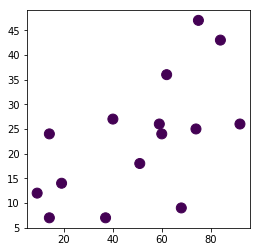

In [28]:
FillVar = 'fch4'
Runs,params = LSTM.Params('Full',FillVar,MP=True)# rpms.Runs,rpms.params
Runs['MSE'] = 0.0
Runs['STD'] = 0.0
print(Runs)
print(params)
plt.figure(figsize = (4,4))
plt.scatter(Runs["N"],Runs['T'],s=100,c=Runs['MSE'])

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Finisehed Run  0
Finisehed Run  1
Finisehed Run  2
Finisehed Run  3
Finisehed Run  4
Finisehed Run  5
Finisehed Run  6
Finisehed Run  7
Finisehed Run  8
Finisehed Run  9
Finisehed Run  10
Finisehed Run  11
Finisehed Run  12
Finisehed Run  13


Using TensorFlow backend.


Finisehed Run  14
     N   T       MSE       STD
0   37   7  0.584848  0.100694
1   68   9  0.599205  0.094361
2   40  27  0.621558  0.089314
3   75  47  0.614457  0.109211
4    9  12  0.608204  0.115647
5   60  24  0.613343  0.169869
6   51  18  0.600764  0.097371
7   74  25  0.615666  0.098286
8   19  14  0.578320  0.080641
9   14   7  0.588574  0.064768
10  14  24  0.595177  0.134043
11  92  26  0.639176  0.133739
12  84  43  0.639939  0.107343
13  62  36  0.678781  0.130173
14  59  26  0.615806  0.132660


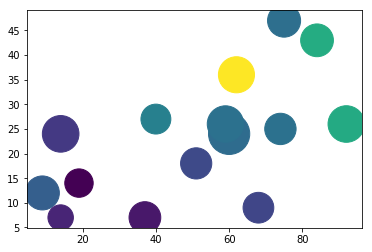

Using TensorFlow backend.


Finisehed Run  

In [29]:
def TTV_Split(i,Memory,X,y,params,X_fill):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=i)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=i)
    return(LSTM.Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,
                            y_val,i,X_fill = X_fill,Memory=Memory))


AllVars = ['H','LE','Fco2','fco2','fch4','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table','Ts 2.5 cm',
         'Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd','ET']

FullModel = ['Wind Spd','air pressure','Ta','PPFD','Ts 2.5 cm','Ts 15 cm',
         'VWC','Active Layer','Rain','Water Table']

# FullModel = ['Wind Spd','air pressure','Water Table','PPFD','Ts 2.5 cm']

Time = time.time()
Path = 'FilteredData2018-04-04.csv'

def RunReps(Model,params,pool = None,plot=False,FullReturn=False):
    RST = RSTF.ReadStandardTimeFill(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    RST.TimeShape(params['T'])
    y = RST.y_time.copy()#*1.0
    X = RST.X_time.copy()#*1.0
    X_fill = RST.X_ftime.copy()
    MSE = []
    STD = []
    Y_fill = []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill),
                                             range(params['reps']))):
            mse = results[0]
            y_fill = results[1]
            Y_fill.append(y_fill)
            MSE.append(mse)
    else:
        for i in range(params['reps']):
            results = TTV_Split(i,Memory,X,y,params,X_fill)
            mse = results[0]
            MSE.append(mse)
            y_fill = results[1]
            Y_fill.append(y_fill)
    MSE = np.asanyarray(MSE)
    Y_fill = np.asanyarray(Y_fill)
    Y_fill = Y_fill.mean(axis=0)
    FillVarName = 'Fch4'
    RST.Fill(Y_fill,FillVarName)
    if plot == True:
        plt.figure(figsize=(5,5))
        plt.plot(RST.Master['Fch4'],color='red')
#         plt.plot(RST.Master['fch4'],color='grey')
        plt.plot(RST.Master['TempFill'],color='blue',alpha=.5)  # This works
        
        yl = plt.ylim()
#         plt.xlim(yl[0],yl[1])
        plt.grid()
    if FullReturn == False:
        return(MSE,RST.Master['TempFill'])
    else:
        return(MSE,RST.Master)

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
    
for i in Runs.index:
    params['T']=Runs['T'].iloc[i]
    params['N']=Runs['N'].iloc[i]
    Results = RunReps(FullModel,params,pool)
    MSE = Results[0]
    Runs['MSE'][i]=MSE.mean()
    Runs['STD'][i]=MSE.std()
    print('Finisehed Run ',str(i))

print(Runs)
plt.scatter(Runs['N'],Runs['T'],c=Runs['MSE'],s=Runs['STD']*1e4)

[ 17.10141841  11.67599647]
17 12


Using TensorFlow backend.


[ 20.03108013  11.14765477]
20 11
[ 16.14206826  15.04045658]
16 15
[ 14.27699437  10.3239231 ]
14 10
[ 19.23387554  17.06093111]
19 17
[ 17.21357553   8.50367022]
17 9
[ 22.12272895  14.01700447]
22 14
[ 24.16671478  11.90728616]
24 12
         MSE   N       STD   T
0   0.608204   9  0.115647  12
1   0.588574  14  0.064768   7
2   0.606548  14  0.075971  10
3   0.595177  14  0.134043  24
4   0.600141  16  0.073895  15
5   0.616100  17  0.089448   9
6   0.583450  17  0.088799  12
7   0.578320  19  0.080641  14
8   0.625460  19  0.116779  17
9   0.605024  20  0.100519  11
10  0.575099  22  0.078391  14
11  0.567366  24  0.080474  12
12  0.584848  37  0.100694   7
13  0.621558  40  0.089314  27
14  0.600764  51  0.097371  18
15  0.615806  59  0.132660  26
16  0.613343  60  0.169869  24
17  0.678781  62  0.130173  36
18  0.599205  68  0.094361   9
19  0.615666  74  0.098286  25
20  0.614457  75  0.109211  47
21  0.639939  84  0.107343  43
22  0.639176  92  0.133739  26
Optimum:
         M

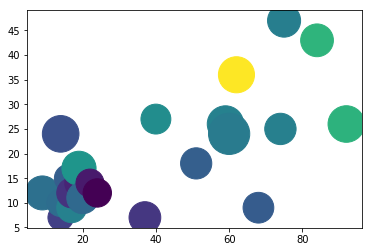

In [30]:

for i in range(params['Searches']):
    kernel = Matern(length_scale_bounds="fixed") 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=1,normalize_y=True)
    gp.fit(Runs[['N','T']].values, Runs['MSE'].values)
    
    next_x = query(Runs[['N','T']].values, Runs['MSE'].values, gp)
    print(next_x)
    N = int(np.round(next_x[0],0))
    T = int(np.round(next_x[1],0))
    o = 0
    while len(Runs.loc[(Runs['N']==N) & (Runs['T']==T)].index) != 0:
        print('Adjust!')
        o +=1
        N += int(o*np.cos(o*np.pi))
        if N < params['N_Min'] or N > params['N_Max']:
            N -= int(o*np.cos(o*np.pi))
        if o > 5:
            T += 1
    print(N,T)
    d = {'N':N,'T':T,'MSE':0,'STD':0}
    idx = Runs.index[-1] + 1
    D2 = pd.DataFrame(data=d,index=[idx])
    Runs = Runs.append(D2)
    
    params['T'] = T
    params['N'] = N
    
    Results = RunReps(FullModel,params,pool)
    MSE = Results[0]
    
    Runs['MSE'][idx]=MSE.mean()
    Runs['STD'][idx]=MSE.std()
    
    Runs = Runs.sort_values(by = ['N','T']).reset_index(drop=True)
    
print(Runs)
Optimum = Runs[Runs['MSE'] == Runs['MSE'].min()]
print('Optimum:')
print(Optimum)
plt.scatter(Runs['N'],Runs['T'],c=Runs['MSE'],s=Runs['STD']*1e4)

['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 2.5 cm', 'Ts 15 cm', 'VWC', 'Active Layer', 'Rain', 'Water Table']
Level:  1

['Wind Spd']

['air pressure']

['Ta']

['PPFD']

['Ts 2.5 cm']

['Ts 15 cm']


Using TensorFlow backend.
Using TensorFlow backend.



['VWC']


Using TensorFlow backend.



['Active Layer']

['Rain']

['Water Table']
['Model: Wind Spd', 'Model: air pressure', 'Model: Ta', 'Model: PPFD', 'Model: Ts 2.5 cm', 'Model: Ts 15 cm', 'Model: VWC', 'Model: Active Layer', 'Model: Rain', 'Model: Water Table']
3
Best:
['PPFD'] 0.821903284409
Level:  2

['Wind Spd', 'PPFD']

['air pressure', 'PPFD']

['Ta', 'PPFD']

['PPFD', 'Ts 2.5 cm']

['PPFD', 'Ts 15 cm']

['PPFD', 'VWC']

['PPFD', 'Active Layer']

['PPFD', 'Rain']

['PPFD', 'Water Table']
['Model: Wind Spd+PPFD', 'Model: air pressure+PPFD', 'Model: Ta+PPFD', 'Model: PPFD+Ts 2.5 cm', 'Model: PPFD+Ts 15 cm', 'Model: PPFD+VWC', 'Model: PPFD+Active Layer', 'Model: PPFD+Rain', 'Model: PPFD+Water Table']
6
Best:
['PPFD', 'Active Layer'] 0.684702663533
Level:  3

['Wind Spd', 'PPFD', 'Active Layer']

['air pressure', 'PPFD', 'Active Layer']


Using TensorFlow backend.
Using TensorFlow backend.



['Ta', 'PPFD', 'Active Layer']

['PPFD', 'Ts 2.5 cm', 'Active Layer']


Using TensorFlow backend.



['PPFD', 'Ts 15 cm', 'Active Layer']

['PPFD', 'VWC', 'Active Layer']

['PPFD', 'Active Layer', 'Rain']

['PPFD', 'Active Layer', 'Water Table']
['Model: Wind Spd+PPFD+Active Layer', 'Model: air pressure+PPFD+Active Layer', 'Model: Ta+PPFD+Active Layer', 'Model: PPFD+Ts 2.5 cm+Active Layer', 'Model: PPFD+Ts 15 cm+Active Layer', 'Model: PPFD+VWC+Active Layer', 'Model: PPFD+Active Layer+Rain', 'Model: PPFD+Active Layer+Water Table']
1
Best:
['air pressure', 'PPFD', 'Active Layer'] 0.593767360496
Level:  4

['Wind Spd', 'air pressure', 'PPFD', 'Active Layer']

['air pressure', 'Ta', 'PPFD', 'Active Layer']

['air pressure', 'PPFD', 'Ts 2.5 cm', 'Active Layer']

['air pressure', 'PPFD', 'Ts 15 cm', 'Active Layer']

['air pressure', 'PPFD', 'VWC', 'Active Layer']

['air pressure', 'PPFD', 'Active Layer', 'Rain']

['air pressure', 'PPFD', 'Active Layer', 'Water Table']
['Model: Wind Spd+air pressure+PPFD+Active Layer', 'Model: air pressure+Ta+PPFD+Active Layer', 'Model: air pressure+PPFD+Ts

Using TensorFlow backend.



['air pressure', 'Ta', 'PPFD', 'Active Layer', 'Water Table']

['air pressure', 'PPFD', 'Ts 2.5 cm', 'Active Layer', 'Water Table']


Using TensorFlow backend.



['air pressure', 'PPFD', 'Ts 15 cm', 'Active Layer', 'Water Table']

['air pressure', 'PPFD', 'VWC', 'Active Layer', 'Water Table']


Using TensorFlow backend.



['air pressure', 'PPFD', 'Active Layer', 'Rain', 'Water Table']
['Model: Wind Spd+air pressure+PPFD+Active Layer+Water Table', 'Model: air pressure+Ta+PPFD+Active Layer+Water Table', 'Model: air pressure+PPFD+Ts 2.5 cm+Active Layer+Water Table', 'Model: air pressure+PPFD+Ts 15 cm+Active Layer+Water Table', 'Model: air pressure+PPFD+VWC+Active Layer+Water Table', 'Model: air pressure+PPFD+Active Layer+Rain+Water Table']
5
Best:
['air pressure', 'PPFD', 'Active Layer', 'Rain', 'Water Table'] 0.582928088068
Level:  6

['Wind Spd', 'air pressure', 'PPFD', 'Active Layer', 'Rain', 'Water Table']

['air pressure', 'Ta', 'PPFD', 'Active Layer', 'Rain', 'Water Table']

['air pressure', 'PPFD', 'Ts 2.5 cm', 'Active Layer', 'Rain', 'Water Table']

['air pressure', 'PPFD', 'Ts 15 cm', 'Active Layer', 'Rain', 'Water Table']

['air pressure', 'PPFD', 'VWC', 'Active Layer', 'Rain', 'Water Table']
['Model: Wind Spd+air pressure+PPFD+Active Layer+Rain+Water Table', 'Model: air pressure+Ta+PPFD+Active 

Using TensorFlow backend.



['Wind Spd', 'air pressure', 'PPFD', 'Ts 2.5 cm', 'VWC', 'Active Layer', 'Rain', 'Water Table']

['Wind Spd', 'air pressure', 'PPFD', 'Ts 15 cm', 'VWC', 'Active Layer', 'Rain', 'Water Table']


Using TensorFlow backend.


['Model: Wind Spd+air pressure+Ta+PPFD+VWC+Active Layer+Rain+Water Table', 'Model: Wind Spd+air pressure+PPFD+Ts 2.5 cm+VWC+Active Layer+Rain+Water Table', 'Model: Wind Spd+air pressure+PPFD+Ts 15 cm+VWC+Active Layer+Rain+Water Table']
0
Best:
['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'VWC', 'Active Layer', 'Rain', 'Water Table'] 0.576190188056
Level:  9

['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 2.5 cm', 'VWC', 'Active Layer', 'Rain', 'Water Table']

['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 15 cm', 'VWC', 'Active Layer', 'Rain', 'Water Table']


Using TensorFlow backend.


['Model: Wind Spd+air pressure+Ta+PPFD+Ts 2.5 cm+VWC+Active Layer+Rain+Water Table', 'Model: Wind Spd+air pressure+Ta+PPFD+Ts 15 cm+VWC+Active Layer+Rain+Water Table']
1
Best:
['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 15 cm', 'VWC', 'Active Layer', 'Rain', 'Water Table'] 0.568709313868
Level:  10

['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 2.5 cm', 'Ts 15 cm', 'VWC', 'Active Layer', 'Rain', 'Water Table']
['Model: Wind Spd+air pressure+Ta+PPFD+Ts 2.5 cm+Ts 15 cm+VWC+Active Layer+Rain+Water Table']
0
Best:
['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 2.5 cm', 'Ts 15 cm', 'VWC', 'Active Layer', 'Rain', 'Water Table'] 0.566248613696
          CI       MSE                                             Models
1   0.069218  0.821903                                        Model: PPFD
2   0.057146  0.684703                           Model: PPFD+Active Layer
3   0.063417  0.593767              Model: air pressure+PPFD+Active Layer
4   0.056766  0.575394  Model: air pressure+PPFD+Active

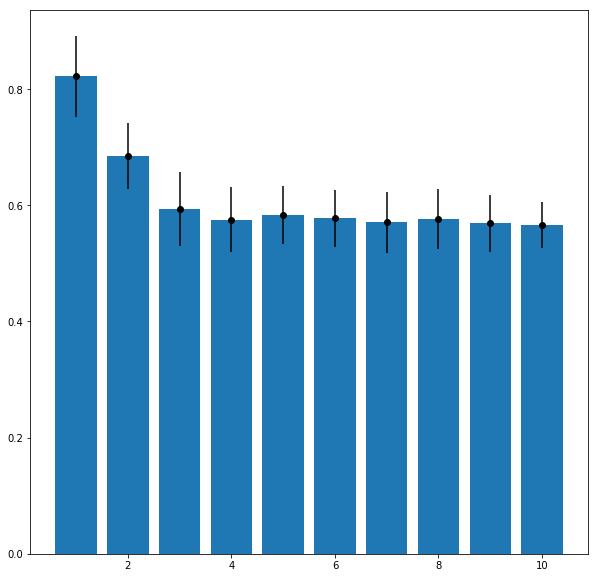

In [31]:
def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor == None:
            Models.append(c)
        else:
            if set(factor).issubset(set(c)):
#             if factor in c:
                Models.append(c)
    return(Models)
params['T']=Optimum['T'].values[0]
params['N']=Optimum['N'].values[0]


Results = RunReps(FullModel,params,pool,FullReturn=True)
FullScore = Results[0]
Data = Results[1]


BestMSE = []
BestSTD = []
idx = []
BestModels = []

print(FullModel)

for i in range(1,len(FullModel)+1):
    print('Level: ',i)
    if i == 1:
        Models = Combos(FullModel,i)
    else:
        Models = Combos(FullModel,i,factor = Best)
#     for model in Models:
    Score = []
    STD = []
    Model_Names = []
    
    for model in Models:
        print()
        print(model)
        Results = RunReps(model,params,pool)
        MSE = Results[0]
        Score.append(MSE.mean())
        STD.append(MSE.std())
        Data['Model: '+'+'.join(model)] = Results[1]
        Model_Names.append('Model: '+'+'.join(model))
        
    Score = np.asanyarray(Score)
    STD = np.asanyarray(STD)
#     print(Model_Names)
#     print(np.where(Score == Score.min())[0][0])
    Best = Models[np.where(Score == Score.min())[0][0]]
    Best_Name = Model_Names[np.where(Score == Score.min())[0][0]]
    BestModels.append(Best_Name)
    BestMSE.append(Score.min())
    BestSTD.append(STD[np.where(Score == Score.min())[0][0]])
    idx.append(i)
    print('Best:')
    print(Best,Score.min())
BestModels = np.asanyarray(BestModels)
BestMSE = np.asanyarray(BestMSE)
BestSTD = np.asanyarray(BestSTD)
idx = np.asanyarray(idx)
BestSE = BestSTD/(params['reps']**.5)
BestCI = BestSE*1.96
plt.figure(figsize=(10,10))
plt.bar(idx,BestMSE)
plt.errorbar(idx,BestMSE,yerr=BestCI,color = 'black',fmt='o')

d = {'Models':BestModels,'MSE':BestMSE,'CI':BestCI}
Stats = pd.DataFrame(index=idx,data=d)
Stats.to_csv('GapFillingSummary'+FillVar+'.csv')
print(Stats)

Data.to_csv('GapFilled'+FillVar+'.csv')

In [32]:

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

print(time.time()-Time)
        

9378.204512357712


In [33]:

# d = {'Models':BestModels,'MSE':BestMSE,'STD':BestSTD}
# Stats = pd.DataFrame(index=idx,data=d)
# Stats.to_csv('GapFillingSummary'+FillVar+'.csv')
# print(Stats)

In [34]:
print(Score)

[ 0.56624861]


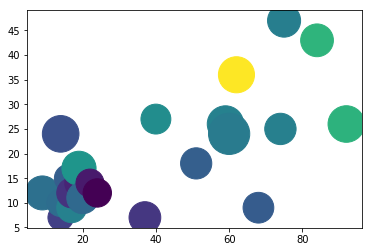

In [35]:

d = {'Models':BestModels,'MSE':BestMSE,'CI':BestCI}
Stats = pd.DataFrame(index=idx,data=d)
Stats.to_csv('GapFillingSummary'+FillVar+'.csv')
# gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=1,normalize_y=True)
# 

# gp.fit(Runs[['N','T']].values, Runs['MSE'].values)

# next_x = query(Runs[['N','T']].values, Runs['MSE'].values, gp)
# print(next_x)
plt.scatter(Runs['N'],Runs['T'],c=Runs['MSE'],s=Runs['STD']*1e4)